# Predictive Modelling

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import warnings
from pandas import read_csv
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

## Import data

In [4]:
root = '/content/gdrive/My Drive/churn_LogisticRegression/'
price_df = pd.read_csv(root + 'price_data.csv', na_values=['n/a', '\s+', 'N/A'])
df = pd.read_csv(root + 'cleaned_data.csv', na_values=['n/a', '\s+', 'N/A'])


In [5]:
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [6]:
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


## Feature Engineering

In [7]:
#1.Price differences between January and December for variable and fix prices

# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference of off peak price
diff_off_peak = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff_off_peak['offpeak_diff_dec_january_var'] = diff_off_peak['dec_1'] - diff_off_peak['price_off_peak_var']
diff_off_peak['offpeak_diff_dec_january_fix'] = diff_off_peak['dec_2'] - diff_off_peak['price_off_peak_fix']
diff_off_peak = diff_off_peak[['id', 'offpeak_diff_dec_january_var','offpeak_diff_dec_january_fix']]
diff_off_peak.head()

,id,offpeak_diff_dec_january_var,offpeak_diff_dec_january_fix
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [8]:
# Group peak prices by companies and month
monthly_peak_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_peak_var': 'mean', 'price_peak_fix': 'mean'}).reset_index()

# Get january and december prices for peak
jan_peak_prices = monthly_peak_price_by_id.groupby('id').first().reset_index()
dec_peak_prices = monthly_peak_price_by_id.groupby('id').last().reset_index()

# Calculate the difference for peak
diff_peak = pd.merge(dec_peak_prices.rename(columns={'price_peak_var': 'dec_1_peak', 'price_peak_fix': 'dec_2_peak'}), jan_peak_prices.drop(columns='price_date'), on='id')
diff_peak['peak_diff_dec_january_var'] = diff_peak['dec_1_peak'] - diff_peak['price_peak_var']
diff_peak['peak_diff_dec_january_fix'] = diff_peak['dec_2_peak'] - diff_peak['price_peak_fix']
diff_peak = diff_peak[['id', 'peak_diff_dec_january_var','peak_diff_dec_january_fix']]
diff_peak.head()


,id,peak_diff_dec_january_var,peak_diff_dec_january_fix
0,0002203ffbb812588b632b9e628cc38d,-0.002302,0.097749
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.005120,0.097749
4,00114d74e963e47177db89bc70108537,0.000000,0.000000


In [9]:
# Group mid-peak prices by companies and month
monthly_mid_peak_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_mid_peak_var': 'mean', 'price_mid_peak_fix': 'mean'}).reset_index()

# Get january and december prices for mid-peak
jan_mid_peak_prices = monthly_mid_peak_price_by_id.groupby('id').first().reset_index()
dec_mid_peak_prices = monthly_mid_peak_price_by_id.groupby('id').last().reset_index()

# Calculate the difference for mid-peak
diff_mid_peak = pd.merge(dec_mid_peak_prices.rename(columns={'price_mid_peak_var': 'dec_1_mid_peak', 'price_mid_peak_fix': 'dec_2_mid_peak'}), jan_mid_peak_prices.drop(columns='price_date'), on='id')
diff_mid_peak['mid_peak_diff_dec_january_var'] = diff_mid_peak['dec_1_mid_peak'] - diff_mid_peak['price_mid_peak_var']
diff_mid_peak['mid_peak_diff_dec_january_fix'] = diff_mid_peak['dec_2_mid_peak'] - diff_mid_peak['price_mid_peak_fix']
diff_mid_peak = diff_mid_peak[['id', 'mid_peak_diff_dec_january_var','mid_peak_diff_dec_january_fix']]
diff_mid_peak.head()


,id,mid_peak_diff_dec_january_var,mid_peak_diff_dec_january_fix
0,0002203ffbb812588b632b9e628cc38d,0.003487,0.065166
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.000763,0.065166
4,00114d74e963e47177db89bc70108537,0.000000,0.000000


In [10]:
# Merge with diff (for off-peak prices)
df = pd.merge(df, diff_off_peak, on='id')

# Merge with diff_peak (for peak prices)
df = pd.merge(df, diff_peak, on='id')

# Merge with diff_mid_peak (for mid-peak prices)
df = pd.merge(df, diff_mid_peak, on='id')

df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_mid_peak,churn,offpeak_diff_dec_january_var,offpeak_diff_dec_january_fix,peak_diff_dec_january_var,peak_diff_dec_january_fix,mid_peak_diff_dec_january_var,mid_peak_diff_dec_january_fix
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,42.629663,12.311304,8.182687,1,0.020057,3.700961,-0.017912,-24.339581,-0.071536,-16.226389
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,44.592310,0.000000,0.000000,0,-0.003767,0.177779,0.000000,0.000000,0.000000,0.000000
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,44.612508,0.088409,0.000000,0,-0.004670,0.177779,0.000528,0.000000,0.000000,0.000000
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,44.593296,0.000000,0.000000,0,-0.004547,0.177779,0.000000,0.000000,0.000000,0.000000
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,40.848791,24.539003,16.365274,0,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166


In [11]:
df.describe()
#df = client + price analysis (year , 6 M , 3 M avg from price data) + (Dec-Jan) price diff

,Unnamed: 0,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_mid_peak,churn,offpeak_diff_dec_january_var,offpeak_diff_dec_january_fix,peak_diff_dec_january_var,peak_diff_dec_january_fix,mid_peak_diff_dec_january_var,mid_peak_diff_dec_january_fix
count,14605.000000,1.460500e+04,1.460500e+04,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,...,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,7302.000000,1.592303e+05,2.809108e+04,16091.371448,1868.638618,1399.858747,0.966450,63.090448,0.137282,0.050488,...,43.197473,9.534975,6.144134,0.097159,-0.004566,0.278502,-0.000827,-0.046056,0.000480,-0.025830
std,4216.244676,5.734836e+05,1.629786e+05,64366.262314,2387.651549,3247.876793,5.108355,66.166636,0.024623,0.049037,...,4.683855,12.179014,7.866460,0.296184,0.012049,1.349277,0.010844,2.186338,0.007119,1.423631
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.148477,-44.266931,-0.143815,-36.344726,-0.098720,-16.724389
25%,3651.000000,5.674000e+03,0.000000e+00,0.000000,494.980000,0.000000,0.000000,16.180000,0.116340,0.000000,...,40.848595,0.000000,0.000000,0.000000,-0.007829,0.000004,-0.002904,0.000000,0.000000,0.000000
50%,7302.000000,1.411600e+04,0.000000e+00,793.000000,1112.610000,314.000000,0.000000,18.800000,0.143166,0.084138,...,44.502379,0.084305,0.000000,0.000000,-0.005344,0.162916,0.000000,0.000000,0.000000,0.000000
75%,10953.000000,4.076400e+04,0.000000e+00,3383.000000,2402.270000,1746.000000,0.000000,131.030000,0.146348,0.098837,...,44.592310,24.537821,16.365180,0.000000,-0.003520,0.177779,0.000000,0.097749,0.000718,0.065166
max,14604.000000,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,...,59.720948,36.610036,17.382386,1.000000,0.168958,40.728885,0.148474,36.490689,0.103502,16.791555


In [12]:
df.columns

Index(['Unnamed: 0', 'id', 'channel_sales', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
       'forecast_price_pow_off_peak', 'has_gas', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max',
       'mean_year_price_off_peak_var', 'mean_year_price_peak_var',
       'mean_year_price_mid_peak_var', 'mean_year_price_off_peak_fix',
       'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix',
       'mean_year_price_off_peak', 'mean_year_price_peak',
       'mean_year_price_mid_peak', 'mean_6m_price_off_peak_var',
       'mean_6m_price_peak_var', 'mean_6m_price_mid_peak_var',
       'mean_6m_price_off_peak_fix', 'mean_6m_price_peak_fix',
       'me

In [13]:
#2.Mean price difference entire year for variable and fix prices

# Selecting important columns
selected_cols = [
    'id',
    'mean_year_price_off_peak_var', 'mean_year_price_peak_var', 'mean_year_price_mid_peak_var',
    'mean_year_price_off_peak_fix', 'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix'
]
different_df = df[selected_cols].copy()

# Calculate the differences for variable prices
different_df['mean_year_peak_mid_var_diff'] = different_df['mean_year_price_peak_var'] - different_df['mean_year_price_mid_peak_var']
different_df['mean_year_peak_off_var_diff'] = different_df['mean_year_price_peak_var'] - different_df['mean_year_price_off_peak_var']
different_df['mean_year_mid_off_var_diff'] = different_df['mean_year_price_mid_peak_var'] - different_df['mean_year_price_off_peak_var']

# Calculate the differences for fixed prices
different_df['mean_year_peak_mid_fix_diff'] = different_df['mean_year_price_peak_fix'] - different_df['mean_year_price_mid_peak_fix']
different_df['mean_year_peak_off_fix_diff'] = different_df['mean_year_price_peak_fix'] - different_df['mean_year_price_off_peak_fix']
different_df['mean_year_mid_off_fix_diff'] = different_df['mean_year_price_mid_peak_fix'] - different_df['mean_year_price_off_peak_fix']



In [14]:
different_df.head()

,id,mean_year_price_off_peak_var,mean_year_price_peak_var,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_peak_mid_var_diff,mean_year_peak_off_var_diff,mean_year_mid_off_var_diff,mean_year_peak_mid_fix_diff,mean_year_peak_off_fix_diff,mean_year_mid_off_fix_diff
0,24011ae4ebbe3035111d65fa7c15bc57,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,0.034219,-0.024038,-0.058257,7.450670,-18.590255,-26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,0.007124,-0.142485,-0.149609,0.000000,-44.311375,-44.311375
2,764c75f661154dac3a6c254cd082ea7d,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,0.088421,-0.082090,-0.170512,0.000000,-44.385450,-44.385450
3,bba03439a292a1e166f80264c16191cb,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,0.000000,-0.151210,-0.151210,0.000000,-44.400265,-44.400265
4,149d57cf92fc41cf94415803a877cb4b,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,0.030773,-0.020536,-0.051309,8.137629,-16.275263,-24.412893


In [15]:
# Select only the 'id' column and the 6 new columns from different_df
different_columns = ['id',
                    'mean_year_peak_mid_var_diff',
                    'mean_year_peak_off_var_diff',
                    'mean_year_mid_off_var_diff',
                    'mean_year_peak_mid_fix_diff',
                    'mean_year_peak_off_fix_diff',
                    'mean_year_mid_off_fix_diff']


In [16]:
# Merge the selected columns with df based on 'id'
df = df.merge(different_df[different_columns], on='id', how='left')

In [17]:
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,peak_diff_dec_january_var,peak_diff_dec_january_fix,mid_peak_diff_dec_january_var,mid_peak_diff_dec_january_fix,mean_year_peak_mid_var_diff,mean_year_peak_off_var_diff,mean_year_mid_off_var_diff,mean_year_peak_mid_fix_diff,mean_year_peak_off_fix_diff,mean_year_mid_off_fix_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,-0.017912,-24.339581,-0.071536,-16.226389,0.034219,-0.024038,-0.058257,7.450670,-18.590255,-26.040925
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,0.000000,0.000000,0.000000,0.007124,-0.142485,-0.149609,0.000000,-44.311375,-44.311375
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000528,0.000000,0.000000,0.000000,0.088421,-0.082090,-0.170512,0.000000,-44.385450,-44.385450
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.151210,-0.151210,0.000000,-44.400265,-44.400265
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,-0.002302,0.097749,0.003487,0.065166,0.030773,-0.020536,-0.051309,8.137629,-16.275263,-24.412893


In [18]:
price_df.columns

Index(['id', 'price_date', 'price_off_peak_var', 'price_peak_var',
       'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix',
       'price_mid_peak_fix'],
      dtype='object')

In [19]:
price_df['price_date']=pd.to_datetime(price_df['price_date'],format='%Y-%m-%d')

In [20]:
# Sort the dataframe
price_df = price_df.sort_values(by=['id', 'price_date'])



In [21]:
price_df

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
72163,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389
72164,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389
72165,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555
72166,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555
72167,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555
...,...,...,...,...,...,...,...,...
115460,ffff7fa066f1fb305ae285bb03bf325a,2015-08-01,0.119916,0.102232,0.076257,40.728885,24.437330,16.291555
115461,ffff7fa066f1fb305ae285bb03bf325a,2015-09-01,0.119916,0.102232,0.076257,40.728885,24.437330,16.291555
115462,ffff7fa066f1fb305ae285bb03bf325a,2015-10-01,0.119916,0.102232,0.076257,40.728885,24.437330,16.291555
115463,ffff7fa066f1fb305ae285bb03bf325a,2015-11-01,0.119916,0.102232,0.076257,40.728885,24.437330,16.291555


In [22]:
# Group by 'id' and calculate standard deviation for specified columns
deviation_df = price_df.groupby('id').agg({
    'price_off_peak_var': 'std',
    'price_peak_var': 'std',
    'price_mid_peak_var': 'std',
    'price_off_peak_fix': 'std',
    'price_peak_fix': 'std',
    'price_mid_peak_fix': 'std'
}).reset_index()

deviation_df.columns = ['id',
                        'std_dev_off_peak_var',
                        'std_dev_peak_var',
                        'std_dev_mid_peak_var',
                        'std_dev_off_peak_fix',
                        'std_dev_peak_fix',
                        'std_dev_mid_peak_fix']

df = df.merge(deviation_df, on='id', how='left')



In [23]:
deviation_df.head()

,id,std_dev_off_peak_var,std_dev_peak_var,std_dev_mid_peak_var,std_dev_off_peak_fix,std_dev_peak_fix,std_dev_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.003976,0.001989,0.001368,6.341481e-02,0.038049,0.025366
1,0004351ebdd665e6ee664792efc4fd13,0.002197,0.000000,0.000000,8.753223e-02,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.026008,0.000000,0.000000,7.723930e-01,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.005049,0.002580,0.000403,8.507958e-02,0.051048,0.034032
4,00114d74e963e47177db89bc70108537,0.002202,0.000000,0.000000,5.908392e-07,0.000000,0.000000


In [24]:
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_year_mid_off_var_diff,mean_year_peak_mid_fix_diff,mean_year_peak_off_fix_diff,mean_year_mid_off_fix_diff,std_dev_off_peak_var,std_dev_peak_var,std_dev_mid_peak_var,std_dev_off_peak_fix,std_dev_peak_fix,std_dev_mid_peak_fix
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,-0.058257,7.450670,-18.590255,-26.040925,0.007829,0.005126,0.020983,1.050136,7.039226,4.692817
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,-0.149609,0.000000,-44.311375,-44.311375,0.002212,0.024677,0.000000,0.080404,0.000000,0.000000
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,-0.170512,0.000000,-44.385450,-44.385450,0.002396,0.000506,0.000000,0.087532,0.000000,0.000000
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,-0.151210,0.000000,-44.400265,-44.400265,0.002317,0.000000,0.000000,0.080403,0.000000,0.000000
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,-0.051309,8.137629,-16.275263,-24.412893,0.003847,0.001885,0.001588,0.073681,0.044209,0.029473


In [25]:
# Group by 'id' and calculate variation for each month
variation_df = price_df.sort_values(by=['id', 'price_date'])

In [26]:
# Calculate monthly differences
variation_df['monthly_diff_off_peak_var'] = variation_df.groupby('id')['price_off_peak_var'].diff()
variation_df['monthly_diff_peak_var'] = variation_df.groupby('id')['price_peak_var'].diff()
variation_df['monthly_diff_mid_peak_var'] = variation_df.groupby('id')['price_mid_peak_var'].diff()

variation_df['monthly_diff_off_peak_fix'] = variation_df.groupby('id')['price_off_peak_fix'].diff()
variation_df['monthly_diff_peak_fix'] = variation_df.groupby('id')['price_peak_fix'].diff()
variation_df['monthly_diff_mid_peak_fix'] = variation_df.groupby('id')['price_mid_peak_fix'].diff()




In [27]:
#3.Maximum monthly price variation for variable and fix prices
# Calculate the maximum monthly variation for each 'id':
max_variation_df = variation_df.groupby('id').agg({
    'monthly_diff_off_peak_var': 'max',
    'monthly_diff_peak_var': 'max',
    'monthly_diff_mid_peak_var': 'max',
    'monthly_diff_off_peak_fix': 'max',
    'monthly_diff_peak_fix': 'max',
    'monthly_diff_mid_peak_fix': 'max'
}).reset_index()

# Rename columns to indicate they represent maximum variation:
max_variation_df.columns = ['id',
                            'max_variation_off_peak_var',
                            'max_variation_peak_var',
                            'max_variation_mid_peak_var',
                            'max_variation_off_peak_fix',
                            'max_variation_peak_fix',
                            'max_variation_mid_peak_fix']



In [28]:
max_variation_df.head()

,id,max_variation_off_peak_var,max_variation_peak_var,max_variation_mid_peak_var,max_variation_off_peak_fix,max_variation_peak_fix,max_variation_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166
1,0004351ebdd665e6ee664792efc4fd13,0.000358,0.000000,0.000000,0.177779,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.052694,0.000000,0.000000,1.500000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.000000,0.000000,0.000817,0.162912,0.097752,0.065172
4,00114d74e963e47177db89bc70108537,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
df = df.merge(max_variation_df, on='id', how='left')

In [30]:
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,std_dev_mid_peak_var,std_dev_off_peak_fix,std_dev_peak_fix,std_dev_mid_peak_fix,max_variation_off_peak_var,max_variation_peak_var,max_variation_mid_peak_var,max_variation_off_peak_fix,max_variation_peak_fix,max_variation_mid_peak_fix
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.020983,1.050136,7.039226,4.692817,0.028554,0.000568,0.002337,3.538045,0.097752,0.065172
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,0.080404,0.000000,0.000000,0.001567,0.085483,0.000000,0.177780,0.000000,0.000000
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000,0.087532,0.000000,0.000000,0.000000,0.001281,0.000000,0.177779,0.000000,0.000000
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.000000,0.080403,0.000000,0.000000,0.000000,0.000000,0.000000,0.177779,0.000000,0.000000
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.001588,0.073681,0.044209,0.029473,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166


In [31]:
df.columns

Index(['Unnamed: 0', 'id', 'channel_sales', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
       'forecast_price_pow_off_peak', 'has_gas', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max',
       'mean_year_price_off_peak_var', 'mean_year_price_peak_var',
       'mean_year_price_mid_peak_var', 'mean_year_price_off_peak_fix',
       'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix',
       'mean_year_price_off_peak', 'mean_year_price_peak',
       'mean_year_price_mid_peak', 'mean_6m_price_off_peak_var',
       'mean_6m_price_peak_var', 'mean_6m_price_mid_peak_var',
       'mean_6m_price_off_peak_fix', 'mean_6m_price_peak_fix',
       'me

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 78 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      14605 non-null  int64  
 1   id                              14605 non-null  object 
 2   channel_sales                   14605 non-null  object 
 3   cons_12m                        14605 non-null  int64  
 4   cons_gas_12m                    14605 non-null  int64  
 5   cons_last_month                 14605 non-null  int64  
 6   date_activ                      14605 non-null  object 
 7   date_end                        14605 non-null  object 
 8   date_modif_prod                 14605 non-null  object 
 9   date_renewal                    14605 non-null  object 
 10  forecast_cons_12m               14605 non-null  float64
 11  forecast_cons_year              14605 non-null  int64  
 12  forecast_discount_energy        

In [33]:
df['date_activ'] = pd.to_datetime(df['date_activ'])
df['date_end'] = pd.to_datetime(df['date_end'])
df['date_modif_prod'] = pd.to_datetime(df['date_modif_prod'])
df['date_renewal'] = pd.to_datetime(df['date_renewal'])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 78 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Unnamed: 0                      14605 non-null  int64         
 1   id                              14605 non-null  object        
 2   channel_sales                   14605 non-null  object        
 3   cons_12m                        14605 non-null  int64         
 4   cons_gas_12m                    14605 non-null  int64         
 5   cons_last_month                 14605 non-null  int64         
 6   date_activ                      14605 non-null  datetime64[ns]
 7   date_end                        14605 non-null  datetime64[ns]
 8   date_modif_prod                 14605 non-null  datetime64[ns]
 9   date_renewal                    14605 non-null  datetime64[ns]
 10  forecast_cons_12m               14605 non-null  float64       
 11  fo

In [35]:
df['channel_sales'].unique()

array(['foosdfpfkusacimwkcsosbicdxkicaua', 'MISSING',
       'lmkebamcaaclubfxadlmueccxoimlema',
       'usilxuppasemubllopkaafesmlibmsdf',
       'ewpakwlliwisiwduibdlfmalxowmwpci',
       'epumfxlbckeskwekxbiuasklxalciiuu',
       'sddiedcslfslkckwlfkdpoeeailfpeds',
       'fixdbufsefwooaasfcxdxadsiekoceaa'], dtype=object)

In [36]:
df['origin_up'].unique()

array(['lxidpiddsbxsbosboudacockeimpuepw',
       'kamkkxfxxuwbdslkwifmmcsiusiuosws',
       'ldkssxwpmemidmecebumciepifcamkci', 'MISSING',
       'usapbepcfoloekilkwsdiboslwaxobdp',
       'ewxeelcelemmiwuafmddpobolfuxioce'], dtype=object)

In [37]:
df['has_gas'].unique()

array(['t', 'f'], dtype=object)

## Data Transformation and Encoding

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [39]:
#feature encoding to change catagorical column to numerical column with LabelEncoder
le = LabelEncoder()

In [40]:
#encode the category columns

columns_encode = ['channel_sales','origin_up','has_gas']

for col in columns_encode:
    df[col + '_encoded'] = le.fit_transform(df[col])


In [41]:
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,std_dev_mid_peak_fix,max_variation_off_peak_var,max_variation_peak_var,max_variation_mid_peak_var,max_variation_off_peak_fix,max_variation_peak_fix,max_variation_mid_peak_fix,channel_sales_encoded,origin_up_encoded,has_gas_encoded
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,4.692817,0.028554,0.000568,0.002337,3.538045,0.097752,0.065172,4,4,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,0.001567,0.085483,0.000000,0.177780,0.000000,0.000000,0,2,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000,0.000000,0.001281,0.000000,0.177779,0.000000,0.000000,4,2,0
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.000000,0.000000,0.000000,0.000000,0.177779,0.000000,0.000000,5,2,0
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.029473,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166,0,2,0


In [42]:
transformed_df = df.copy()

In [43]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 81 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Unnamed: 0                      14605 non-null  int64         
 1   id                              14605 non-null  object        
 2   channel_sales                   14605 non-null  object        
 3   cons_12m                        14605 non-null  int64         
 4   cons_gas_12m                    14605 non-null  int64         
 5   cons_last_month                 14605 non-null  int64         
 6   date_activ                      14605 non-null  datetime64[ns]
 7   date_end                        14605 non-null  datetime64[ns]
 8   date_modif_prod                 14605 non-null  datetime64[ns]
 9   date_renewal                    14605 non-null  datetime64[ns]
 10  forecast_cons_12m               14605 non-null  float64       
 11  fo

In [44]:
print(transformed_df.columns)

Index(['Unnamed: 0', 'id', 'channel_sales', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
       'forecast_price_pow_off_peak', 'has_gas', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max',
       'mean_year_price_off_peak_var', 'mean_year_price_peak_var',
       'mean_year_price_mid_peak_var', 'mean_year_price_off_peak_fix',
       'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix',
       'mean_year_price_off_peak', 'mean_year_price_peak',
       'mean_year_price_mid_peak', 'mean_6m_price_off_peak_var',
       'mean_6m_price_peak_var', 'mean_6m_price_mid_peak_var',
       'mean_6m_price_off_peak_fix', 'mean_6m_price_peak_fix',
       'me

In [45]:
#drop unused columns
transformed_df.drop(['Unnamed: 0','id','channel_sales','origin_up','has_gas'], axis=1, inplace=True)

In [46]:
print(transformed_df.columns)

Index(['cons_12m', 'cons_gas_12m', 'cons_last_month', 'date_activ', 'date_end',
       'date_modif_prod', 'date_renewal', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max',
       'mean_year_price_off_peak_var', 'mean_year_price_peak_var',
       'mean_year_price_mid_peak_var', 'mean_year_price_off_peak_fix',
       'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix',
       'mean_year_price_off_peak', 'mean_year_price_peak',
       'mean_year_price_mid_peak', 'mean_6m_price_off_peak_var',
       'mean_6m_price_peak_var', 'mean_6m_price_mid_peak_var',
       'mean_6m_price_off_peak_fix', 'mean_6m_price_peak_fix',
       'mean_6m_price_mid_peak_fix', 'mean_6m_price_off_peak',
       'mean_6m

In [47]:
transformed_df = transformed_df.select_dtypes(exclude=['datetime64'])
transformed_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 72 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cons_12m                        14605 non-null  int64  
 1   cons_gas_12m                    14605 non-null  int64  
 2   cons_last_month                 14605 non-null  int64  
 3   forecast_cons_12m               14605 non-null  float64
 4   forecast_cons_year              14605 non-null  int64  
 5   forecast_discount_energy        14605 non-null  float64
 6   forecast_meter_rent_12m         14605 non-null  float64
 7   forecast_price_energy_off_peak  14605 non-null  float64
 8   forecast_price_energy_peak      14605 non-null  float64
 9   forecast_price_pow_off_peak     14605 non-null  float64
 10  imp_cons                        14605 non-null  float64
 11  margin_gross_pow_ele            14605 non-null  float64
 12  margin_net_pow_ele              

In [48]:

original_column_names = transformed_df.columns

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(transformed_df)

# Convert the numpy array to DataFrame immediately after scaling
final_transformed_df = pd.DataFrame(scaled_array, columns=original_column_names)


In [49]:
final_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 72 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cons_12m                        14605 non-null  float64
 1   cons_gas_12m                    14605 non-null  float64
 2   cons_last_month                 14605 non-null  float64
 3   forecast_cons_12m               14605 non-null  float64
 4   forecast_cons_year              14605 non-null  float64
 5   forecast_discount_energy        14605 non-null  float64
 6   forecast_meter_rent_12m         14605 non-null  float64
 7   forecast_price_energy_off_peak  14605 non-null  float64
 8   forecast_price_energy_peak      14605 non-null  float64
 9   forecast_price_pow_off_peak     14605 non-null  float64
 10  imp_cons                        14605 non-null  float64
 11  margin_gross_pow_ele            14605 non-null  float64
 12  margin_net_pow_ele              

In [50]:
!pip install xgboost

Model: RandomForestClassifier, Test Size: 0.2
Accuracy: 0.9028
Precision: 0.5000
Recall: 0.0282
F1-score: 0.0533



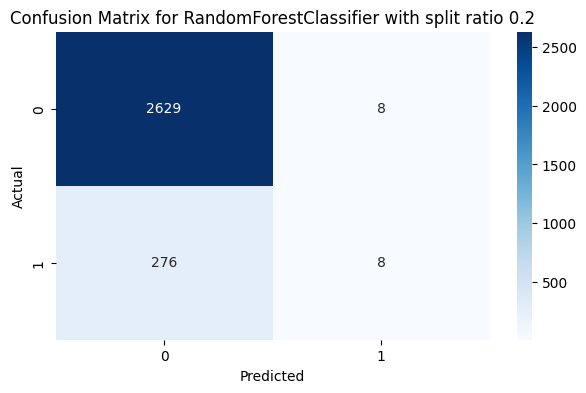

Model: DecisionTreeClassifier, Test Size: 0.2
Accuracy: 0.8322
Precision: 0.1520
Recall: 0.1585
F1-score: 0.1552



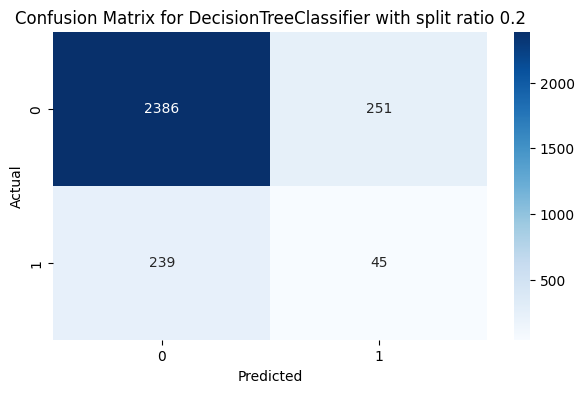

Model: XGBClassifier, Test Size: 0.2
Accuracy: 0.9055
Precision: 0.5909
Recall: 0.0915
F1-score: 0.1585



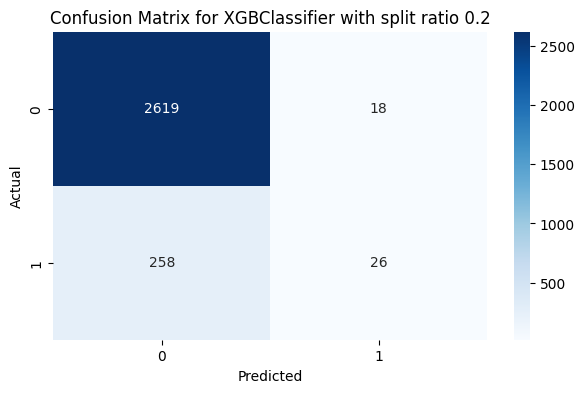

Model: LogisticRegression, Test Size: 0.2
Accuracy: 0.5827
Precision: 0.1439
Recall: 0.6655
F1-score: 0.2367



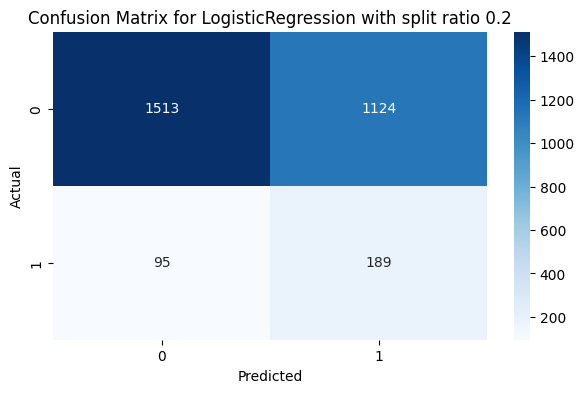

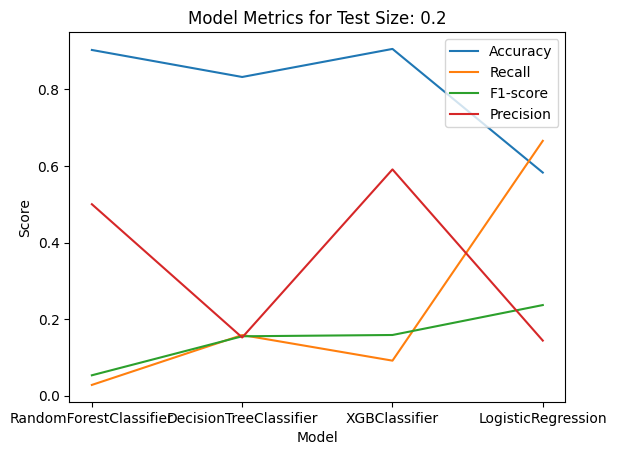

-----------------------------------------------------------------------------------------
Model: RandomForestClassifier, Test Size: 0.3
Accuracy: 0.9042
Precision: 0.6818
Recall: 0.0350
F1-score: 0.0667



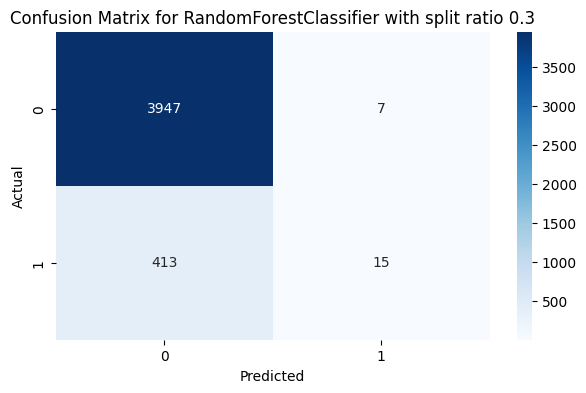

Model: DecisionTreeClassifier, Test Size: 0.3
Accuracy: 0.8336
Precision: 0.1805
Recall: 0.1986
F1-score: 0.1891



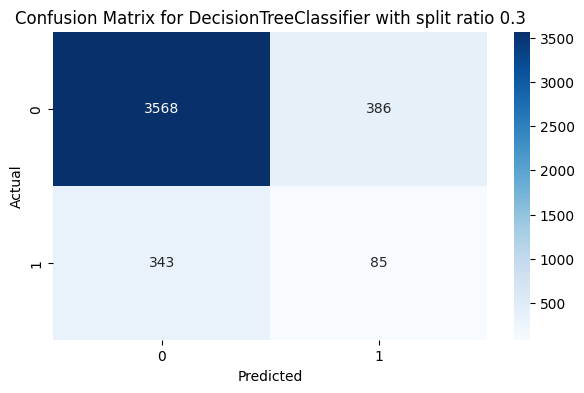

Model: XGBClassifier, Test Size: 0.3
Accuracy: 0.9000
Precision: 0.4306
Recall: 0.0724
F1-score: 0.1240



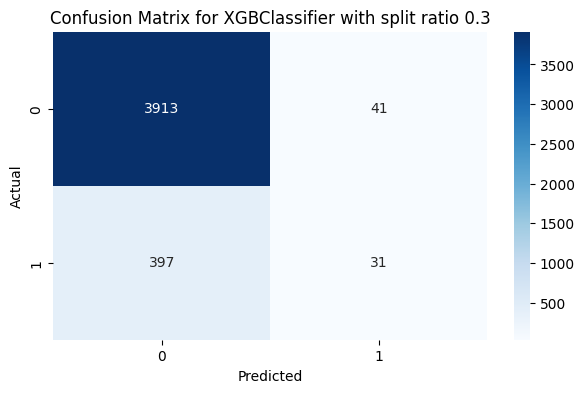

Model: LogisticRegression, Test Size: 0.3
Accuracy: 0.5614
Precision: 0.1381
Recall: 0.6659
F1-score: 0.2287



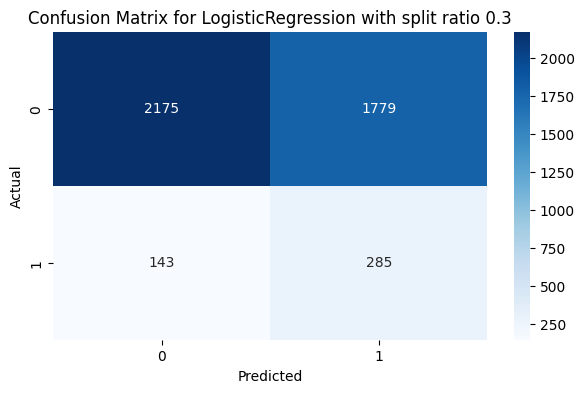

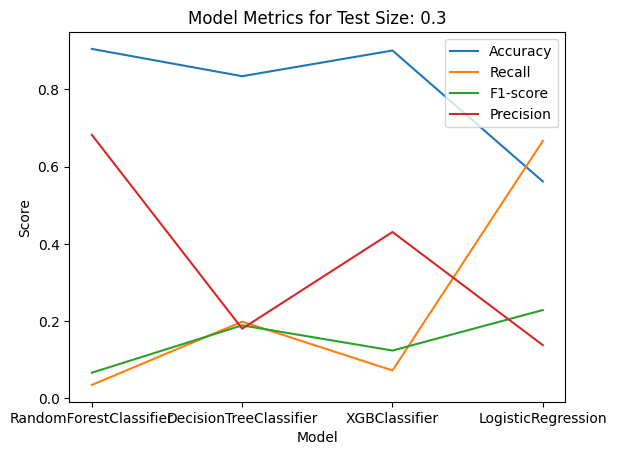

-----------------------------------------------------------------------------------------


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Separate features and target variable based on the "churn" column
X = final_transformed_df.drop(columns=['churn'])
Y = final_transformed_df['churn']

models = [
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    XGBClassifier(),
    LogisticRegression(class_weight='balanced',solver='lbfgs', max_iter=1000)
]
split_ratios = [0.2,0.3]
model_perf = pd.DataFrame(columns=['Model_Name', 'K_Folds', 'Accuracy', 'Precision', 'Recall', 'F1'])


# Loop over split ratios
for split in split_ratios:
    accuracy_scores = []
    recall_scores = []
    f1_scores = []
    precision_scores = []

    # Loop over models
    for model in models:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split, random_state=1)

        # Train the model
        model.fit(X_train, Y_train)

        # Make predictions
        Y_pred = model.predict(X_test)

        # Calculate accuracy, precision, recall, and F1-score
        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred)
        recall = recall_score(Y_test, Y_pred)
        f1 = f1_score(Y_test, Y_pred)

        print(f"Model: {type(model).__name__}, Test Size: {split}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}\n")

        # Plot the confusion matrix
        plt.figure(figsize=(7, 4))
        sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='Blues', fmt='')
        plt.title(f'Confusion Matrix for {type(model).__name__} with split ratio {split}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Append scores to the lists
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)


        new_row = {
            'Model_Name': type(model).__name__,
            'Split ratio': split,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        }
        model_perf = pd.concat([model_perf, pd.DataFrame([new_row])], ignore_index=True)


    # Plot the graph for the current split ratio
    plt.plot([type(model).__name__ for model in models], accuracy_scores, label='Accuracy')
    plt.plot([type(model).__name__ for model in models], recall_scores, label='Recall')
    plt.plot([type(model).__name__ for model in models], f1_scores, label='F1-score')
    plt.plot([type(model).__name__ for model in models], precision_scores, label='Precision')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title(f'Model Metrics for Test Size: {split}')
    plt.legend()
    plt.show()

    print("-----------------------------------------------------------------------------------------")



In [52]:
print(model_perf)

               Model_Name K_Folds  Accuracy  Precision    Recall        F1  \
0  RandomForestClassifier     NaN  0.902773   0.500000  0.028169  0.053333   
1  DecisionTreeClassifier     NaN  0.832249   0.152027  0.158451  0.155172   
2           XGBClassifier     NaN  0.905512   0.590909  0.091549  0.158537   
3      LogisticRegression     NaN  0.582677   0.143945  0.665493  0.236694   
4  RandomForestClassifier     NaN  0.904153   0.681818  0.035047  0.066667   
5  DecisionTreeClassifier     NaN  0.833638   0.180467  0.198598  0.189099   
6           XGBClassifier     NaN  0.900046   0.430556  0.072430  0.124000   
7      LogisticRegression     NaN  0.561387   0.138081  0.665888  0.228732   

   Split ratio  
0          0.2  
1          0.2  
2          0.2  
3          0.2  
4          0.3  
5          0.3  
6          0.3  
7          0.3  
